# Bike count forecasting using RNN

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# deep learning libraries
from keras.models import Input, Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, SimpleRNN
from keras.layers import Conv1D, MaxPooling1D
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import initializers

Using TensorFlow backend.


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import and basic analysis

In [3]:
DATADIR = '../data/bike/'
MODELDIR = '../checkpoints/bike-sharing/rnn/'

data_path = os.path.join(DATADIR, 'bike-sharing-processed.csv')
data = pd.read_csv(data_path)

In [4]:
data.set_index('date', inplace=True)
data.sort_index(inplace=True)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
date,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


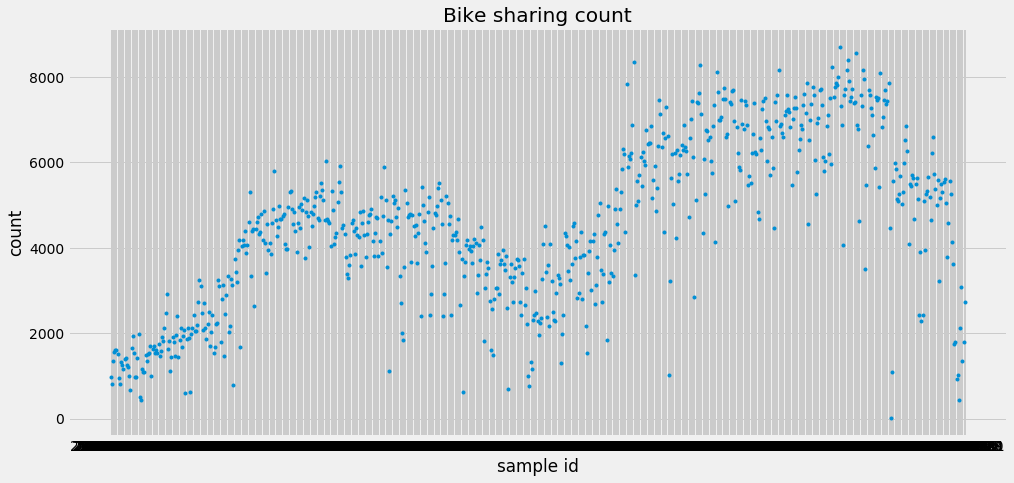

In [5]:
plt.plot(data.cnt, '.')
plt.title('Bike sharing count')
plt.xlabel('sample id')
plt.ylabel('count')
plt.show()

## 2. Data preparation

In [6]:
y = data[['cnt']].copy()
X = data.drop(columns=['cnt'], axis=1)

print(f'X and y shape:')
print(X.shape, y.shape)

# date selection
datelist = data.index.unique()

# two month data for testset
print(f'Test start date: {datelist[-61]}')

# Train test split : last 60 days for test set

X_train = X[X.index < datelist[-61]]
X_test = X[X.index >= datelist[-61]]

y_train = y[y.index < datelist[-61]]
y_test = y[y.index >= datelist[-61]]


print(f'Size of train and test set respectively:')
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

X and y shape:
(731, 12) (731, 1)
Test start date: 2012-11-01
Size of train and test set respectively:
(670, 12) (61, 12) (670, 1) (61, 1)


In [7]:
timesteps = 1
features = X_train.shape[1]
xavier = initializers.glorot_normal()

X_train = np.reshape(X_train.values, (X_train.shape[0], timesteps, features))
X_test = np.reshape(X_test.values, (X_test.shape[0], timesteps, features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((670, 1, 12), (61, 1, 12), (670, 1), (61, 1))

## 3. Model building

In [8]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    # MAE and NRMSE calculation
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_nrmse = train_rmse/np.std(y_train.values)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_nrmse = test_rmse/np.std(y_test.values)

    print(f'Training MAE: {np.round(train_mae, 3)}')
    print(f'Trainig NRMSE: {np.round(train_nrmse, 3)}')
    print()

    print(f'Test MAE: {np.round(test_mae)}')
    print(f'Test NRMSE: {np.round(test_nrmse)}')
    
    return

In [9]:
def model_training(X_train, X_test, y_train, model, batch=8, name='m'):
    start = time.time()
    loss = losses.mean_squared_error
    opt = optimizers.Adam()
    metric = [metrics.mean_absolute_error]
    model.compile(loss=loss, optimizer=opt, metrics=metric)

    callbacks_list = [callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)]

    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=batch, 
                        verbose=0,
                        shuffle=False,
                        callbacks=callbacks_list
                       )

    # save model weights and 
    if os.path.exists(MODELDIR):
        pass
    else:
        os.makedirs(MODELDIR)
    m_name = name + str('.h5')
    w_name = name + str('_w.h5')
    model.save(os.path.join(MODELDIR, m_name))
    model.save_weights(os.path.join(MODELDIR, w_name))

    # prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    end = time.time()
    time_taken = np.round((end-start), 3)
    print(f'Time taken to complete the process: {time_taken} seconds')
    
    return y_train_pred, y_test_pred, history

### RNN - v1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 3)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 9.143 seconds
Training MAE: 3132.46
Trainig NRMSE: 1.835

Test MAE: 2698.0
Test NRMSE: 2.0


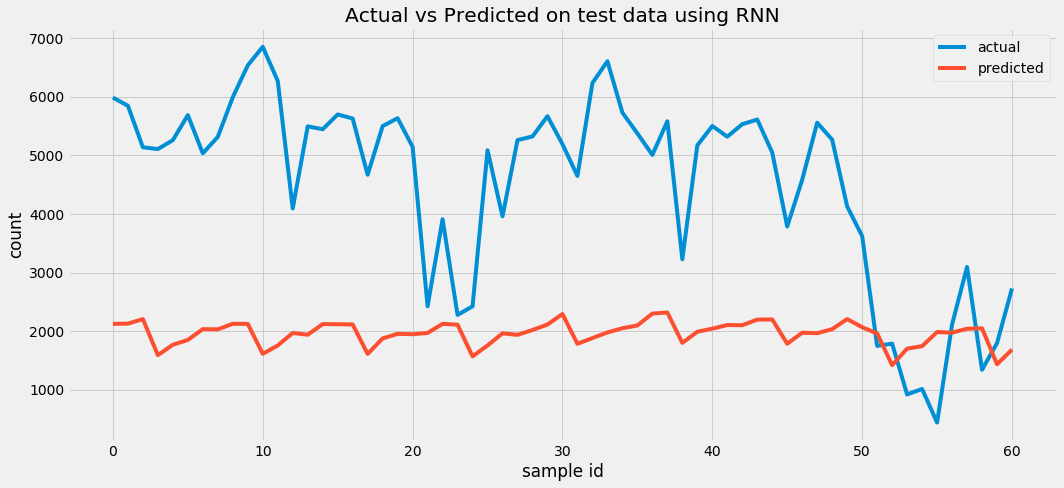

In [10]:
model = Sequential()
model.add(SimpleRNN(3, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))
model.summary()


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=8, name='rnn-v1')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using RNN')
plt.legend()
plt.tight_layout()
plt.show()

## RNN - v2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 1, 3)              48        
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 1, 3)              21        
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 3)                 21        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 15.411 seconds
Training MAE: 4494.103
Trainig NRMSE: 2.496

Test MAE: 4523.0
Test NRMSE: 3.0


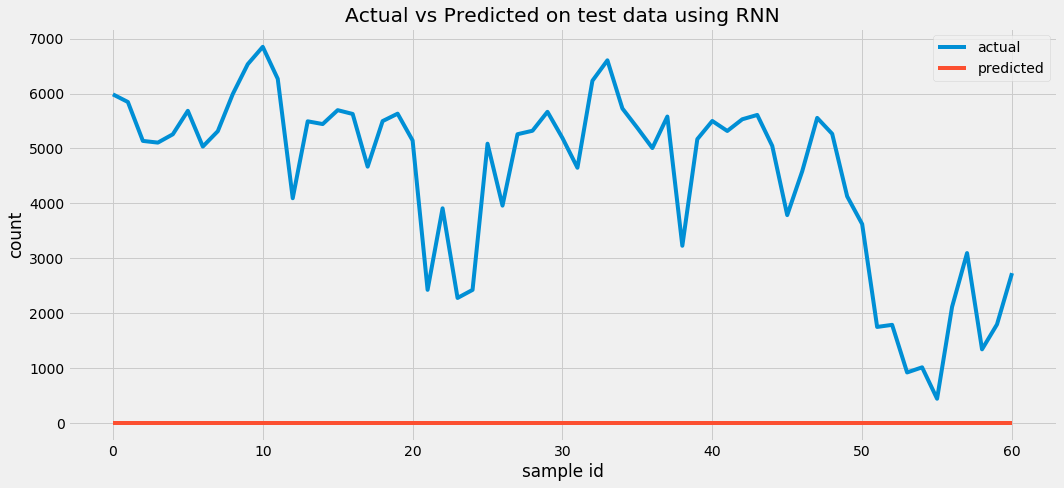

In [13]:
model = Sequential()
model.add(SimpleRNN(3, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu', return_sequences=True))
model.add(SimpleRNN(3, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(SimpleRNN(3, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))
model.summary()


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=8, name='rnn-v2')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using RNN')
plt.legend()
plt.tight_layout()
plt.show()

## RNN - v3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 1, 8)              168       
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 1, 16)             400       
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 8)                 200       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 777
Trainable params: 777
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 15.659 seconds
Training MAE: 844.919
Trainig NRMSE: 0.549

Test MAE: 1711.0
Test NRMSE: 1.0


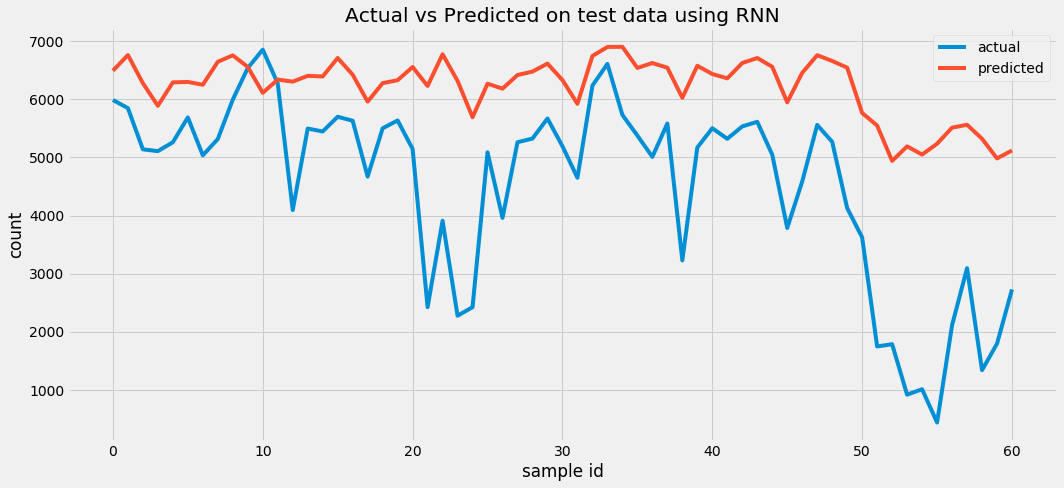

In [14]:
model = Sequential()
model.add(SimpleRNN(8, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu', return_sequences=True))
model.add(SimpleRNN(16, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(SimpleRNN(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))
model.summary()


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=8, name='rnn-v3')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using RNN')
plt.legend()
plt.tight_layout()
plt.show()

## RNN - v4

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 1, 8)              168       
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 1, 16)             400       
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 8)                 200       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 777
Trainable params: 777
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 8.583 seconds
Training MAE: 1255.245
Trainig NRMSE: 0.793

Test MAE: 1798.0
Test NRMSE: 1.0


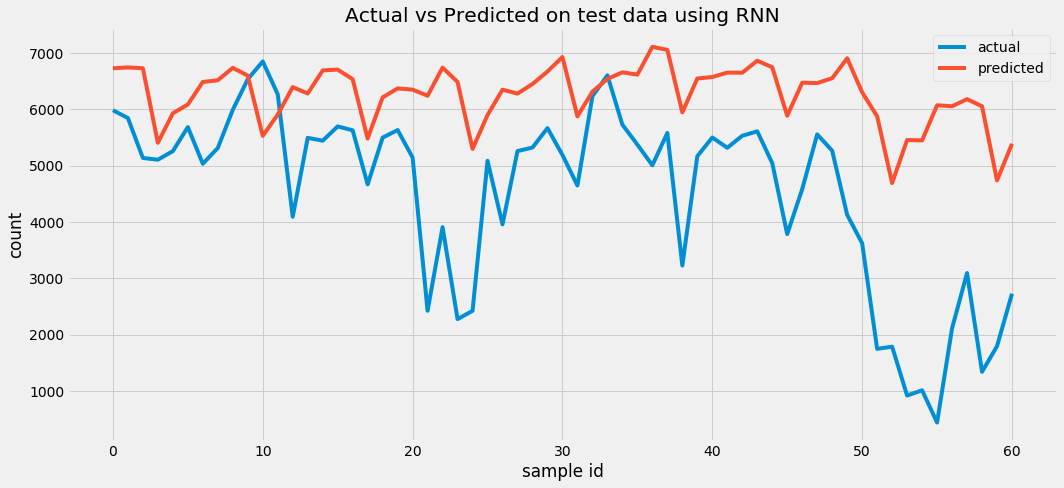

In [15]:
model = Sequential()
model.add(SimpleRNN(8, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu', return_sequences=True))
model.add(SimpleRNN(16, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(SimpleRNN(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))
model.summary()


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=16, name='rnn-v4')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using RNN')
plt.legend()
plt.tight_layout()
plt.show()

## RNN - v5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 1, 8)              168       
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 1, 16)             400       
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 8)                 200       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 777
Trainable params: 777
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 30.338 seconds
Training MAE: 704.593
Trainig NRMSE: 0.471

Test MAE: 1275.0
Test NRMSE: 1.0


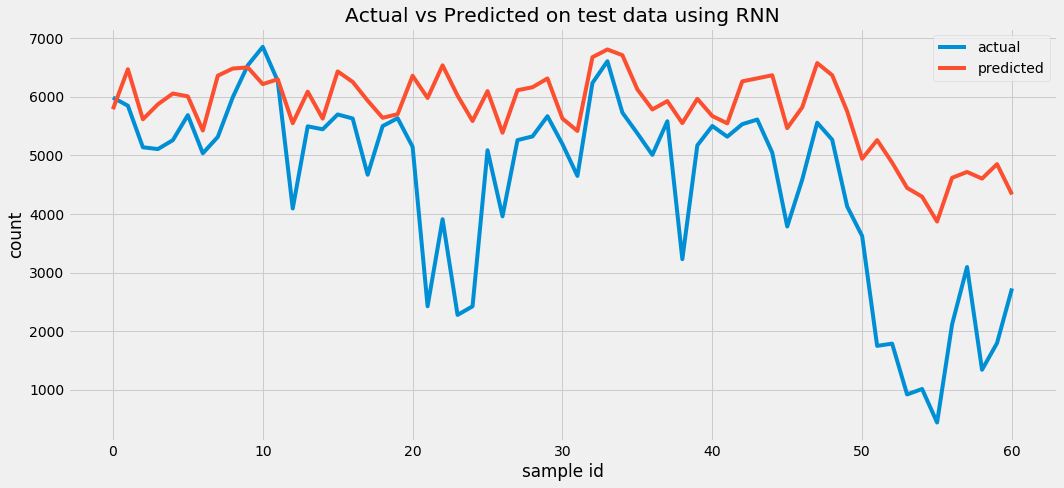

In [16]:
model = Sequential()
model.add(SimpleRNN(8, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu', return_sequences=True))
model.add(SimpleRNN(16, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(SimpleRNN(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))
model.summary()


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='rnn-v5')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using RNN')
plt.legend()
plt.tight_layout()
plt.show()

### RNN - v6 (final model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_22 (SimpleRNN)    (None, 1, 8)              168       
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, 1, 16)             400       
_________________________________________________________________
simple_rnn_24 (SimpleRNN)    (None, 1, 16)             528       
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, 8)                 200       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,305
Trainable params: 1,305
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 72.353 seconds
Training MAE: 651.45
Trainig NRMSE: 0.454

Test MAE: 1253.0
Test NRMSE: 1.0


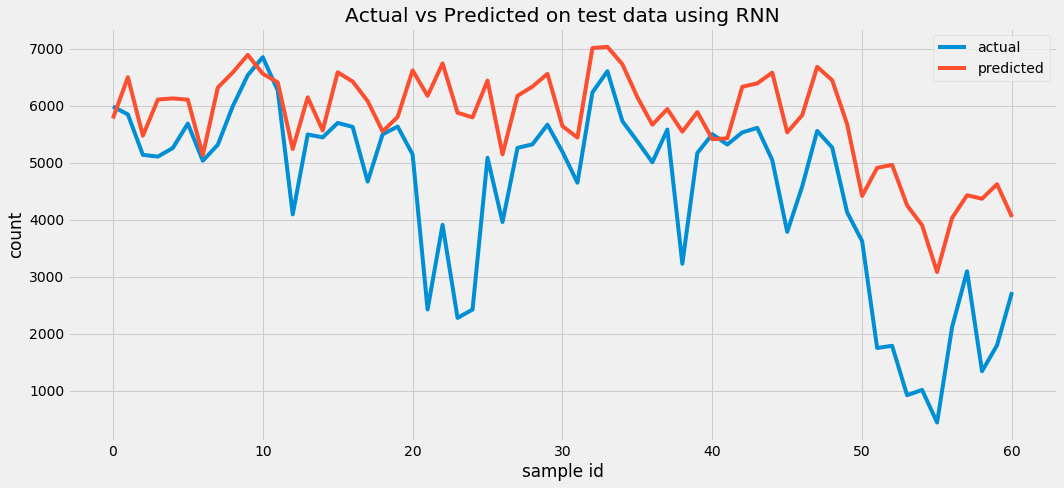

In [18]:
model = Sequential()
model.add(SimpleRNN(8, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu', return_sequences=True))
model.add(SimpleRNN(16, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(SimpleRNN(16, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(SimpleRNN(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))
model.summary()


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='rnn-v6')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using RNN')
plt.legend()
plt.tight_layout()
plt.show()

### RNN-v7

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_26 (SimpleRNN)    (None, 1, 8)              168       
_________________________________________________________________
simple_rnn_27 (SimpleRNN)    (None, 1, 16)             400       
_________________________________________________________________
simple_rnn_28 (SimpleRNN)    (None, 1, 16)             528       
_________________________________________________________________
simple_rnn_29 (SimpleRNN)    (None, 1, 8)              200       
_________________________________________________________________
simple_rnn_30 (SimpleRNN)    (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________
Time tak

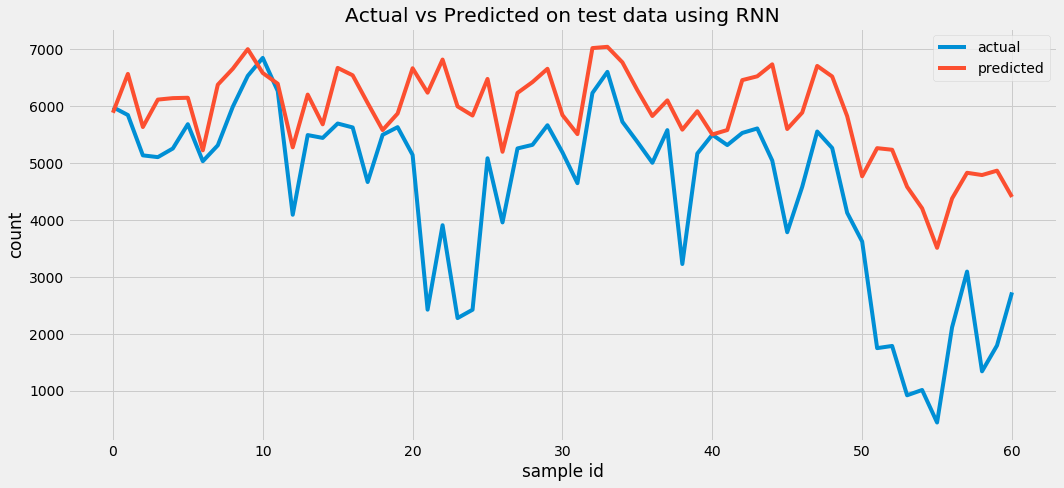

In [19]:
model = Sequential()
model.add(SimpleRNN(8, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu', return_sequences=True))
model.add(SimpleRNN(16, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(SimpleRNN(16, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(SimpleRNN(8, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(SimpleRNN(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))
model.summary()


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='rnn-v7')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using RNN')
plt.legend()
plt.tight_layout()
plt.show()